In [34]:
from SecureBitcoin_utils import *
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import requests

# For analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Derive encryption key
key = derive_key("Shri200206*")

In [35]:
def fetch_hourly_data(days=15):
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": str(days)
        # Do NOT include "interval": "hourly" — it requires enterprise plan
    }

    response = requests.get(url, params=params)
    
    try:
        response.raise_for_status()
        json_data = response.json()

        if "prices" not in json_data:
            raise ValueError("Missing 'prices' in response")

        raw = json_data["prices"]  # List of [timestamp, price]

        hourly_data = [{
            "timestamp": datetime.fromtimestamp(t / 1000, tz=timezone.utc).isoformat(),
            "price_usd": price
        } for t, price in raw]

        return hourly_data

    except Exception as e:
        print("Error fetching data:", e)
        print("Response:", response.text)
        return []

In [36]:
# Fetch & Encrypt
hourly_entries = fetch_hourly_data(days=15)
encrypted_entries = [encrypt_data(entry, key) for entry in hourly_entries]

# Decrypt entries
decrypted_entries = [decrypt_data(e, key) for e in encrypted_entries]

# Load into DataFrame
df = pd.DataFrame(decrypted_entries)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
df = df.sort_values('timestamp').set_index('timestamp')
df['price_usd'] = df['price_usd'].astype(float)

df.head()


,price_usd
timestamp,
2025-05-01 17:12:29.704000+00:00,97176.445404
2025-05-01 18:03:00.814000+00:00,96792.531456
2025-05-01 19:03:13.844000+00:00,96867.060520
2025-05-01 20:09:55.033000+00:00,96463.639762
2025-05-01 21:05:05.352000+00:00,96468.249297


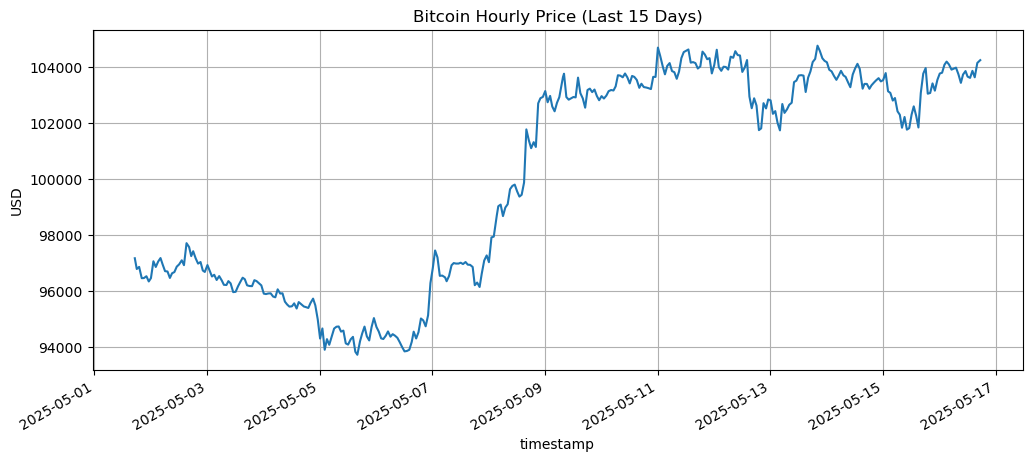

In [38]:
df['price_usd'].plot(figsize=(12, 5), title="Bitcoin Hourly Price (Last 15 Days)")
plt.ylabel("USD")
plt.grid(True)
plt.show()

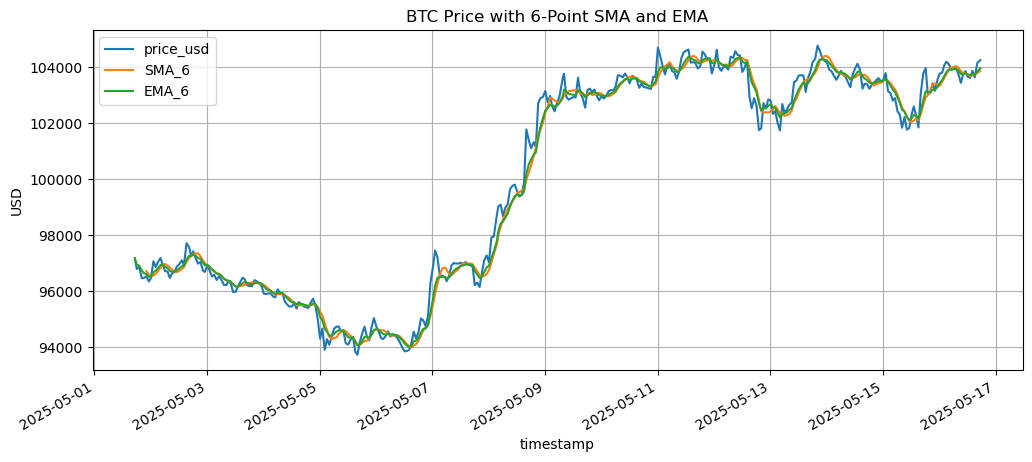

In [39]:
df['SMA_6'] = df['price_usd'].rolling(window=6).mean()
df['EMA_6'] = df['price_usd'].ewm(span=6).mean()

df[['price_usd', 'SMA_6', 'EMA_6']].plot(figsize=(12, 5), title="BTC Price with 6-Point SMA and EMA")
plt.ylabel("USD")
plt.grid(True)
plt.show()

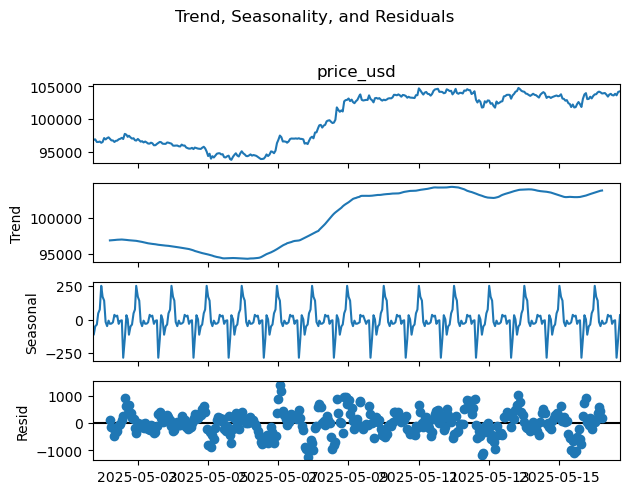

In [40]:
result = seasonal_decompose(df['price_usd'], model='additive', period=24)
result.plot()
plt.suptitle("Trend, Seasonality, and Residuals", y=1.02)
plt.tight_layout()
plt.show()

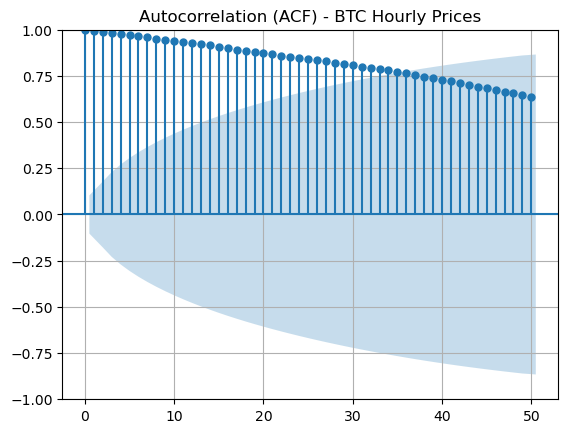

In [41]:
plot_acf(df['price_usd'], lags=50)
plt.title("Autocorrelation (ACF) - BTC Hourly Prices")
plt.grid(True)
plt.show()